# Latihan 3 — Elastic Net Tanpa Pipeline

Latihan ini meniru alur di `lesson_05_Elastic_Net_The_Best_of_Both_Worlds`, tetapi **tanpa `Pipeline`**.

Urutan langkahnya:
1) Buat fitur polinomial, 2) scaling, 3) fit ElasticNet, 4) bandingkan koefisien dengan Ridge & Lasso.

---
## 1) Intuisi singkat
Elastic Net menggabungkan penalti L1 (Lasso) dan L2 (Ridge).
- `alpha`: kekuatan regularisasi total (makin besar → makin kuat).
- `l1_ratio`: campuran L1 vs L2.
  - `l1_ratio=0` → Ridge murni
  - `l1_ratio=1` → Lasso murni
  - nilai di tengah → campuran keduanya

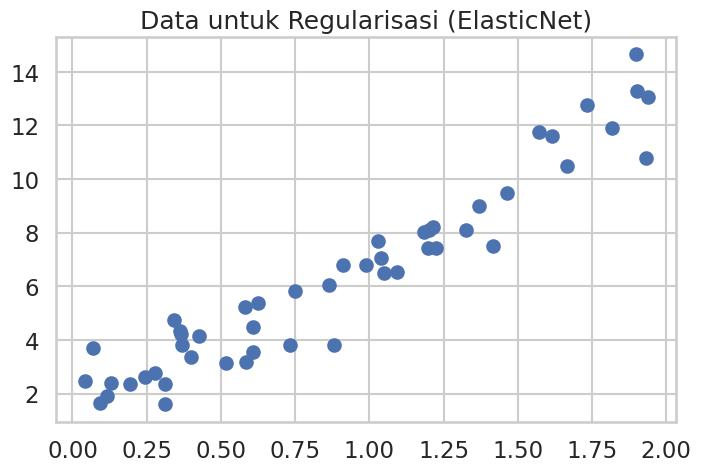

In [7]:
# Setup: import & data (mengikuti lesson_05, tapi tanpa Pipeline)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso

sns.set_theme(style="whitegrid", context="talk")
np.set_printoptions(precision=2, floatmode="fixed", suppress=True)

# Data
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (2 + 3*X + 1.5*X**2 + np.random.randn(m, 1)).ravel()

plt.figure(figsize=(8, 5))
plt.scatter(X, y)
plt.title("Data untuk Regularisasi (ElasticNet)")
plt.show()

---
## 2) Preprocessing manual (tanpa Pipeline)
Di lesson_05, `Pipeline` dipakai untuk: `PolynomialFeatures(degree=20)` lalu `StandardScaler()`.
Di sini kita lakukan manual dengan `fit_transform` sekali pada data training.

In [8]:
degree = 20
poly = PolynomialFeatures(degree=degree, include_bias=False)
scaler = StandardScaler()

X_poly = poly.fit_transform(X)
X_poly_scaled = scaler.fit_transform(X_poly)

print("Shape X asli:", X.shape)
print("Shape setelah poly:", X_poly.shape)
print("Shape setelah scaling:", X_poly_scaled.shape)

Shape X asli: (50, 1)
Shape setelah poly: (50, 20)
Shape setelah scaling: (50, 20)


---
## 3) Fit ElasticNet (tanpa Pipeline)
Kita latih ElasticNet dengan contoh parameter seperti di lesson_05: `alpha=0.1` dan `l1_ratio=0.5`.

In [9]:
alpha = 0.1
l1_ratio = 0.5

elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=10000)
elastic_net.fit(X_poly_scaled, y)
elastic_net_coeffs = elastic_net.coef_

print(f"ElasticNet alpha={alpha}, l1_ratio={l1_ratio}")
print("Koefisien ElasticNet (ringkas):")
print(elastic_net_coeffs)

ElasticNet alpha=0.1, l1_ratio=0.5
Koefisien ElasticNet (ringkas):
[ 1.56  1.07  0.59  0.19  0.00  0.00  0.00  0.00  0.00 -0.00 -0.00 -0.00
 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.05 -0.11]


---
## 4) Bandingkan koefisien vs Ridge & Lasso
Kita latih Ridge dan Lasso pada data hasil preprocessing yang sama, lalu bandingkan koefisiennya.

In [10]:
# Fit Ridge & Lasso untuk perbandingan
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_poly_scaled, y)
ridge_coeffs = ridge.coef_

lasso = Lasso(alpha=0.1, max_iter=10000, random_state=42)
lasso.fit(X_poly_scaled, y)
lasso_coeffs = lasso.coef_

# DataFrame koefisien
coeffs_df = pd.DataFrame({
    "Feature": [f"X^{i+1}" for i in range(X_poly_scaled.shape[1])],
    "Ridge": ridge_coeffs,
    "Lasso": lasso_coeffs,
    "ElasticNet": elastic_net_coeffs,
})

print(coeffs_df.head())

  Feature     Ridge     Lasso  ElasticNet
0     X^1  1.679773  1.641557    1.563576
1     X^2  0.965124  1.639009    1.067809
2     X^3  0.499973  0.000000    0.585891
3     X^4  0.259764  0.000000    0.189520
4     X^5  0.149161  0.000000    0.000000


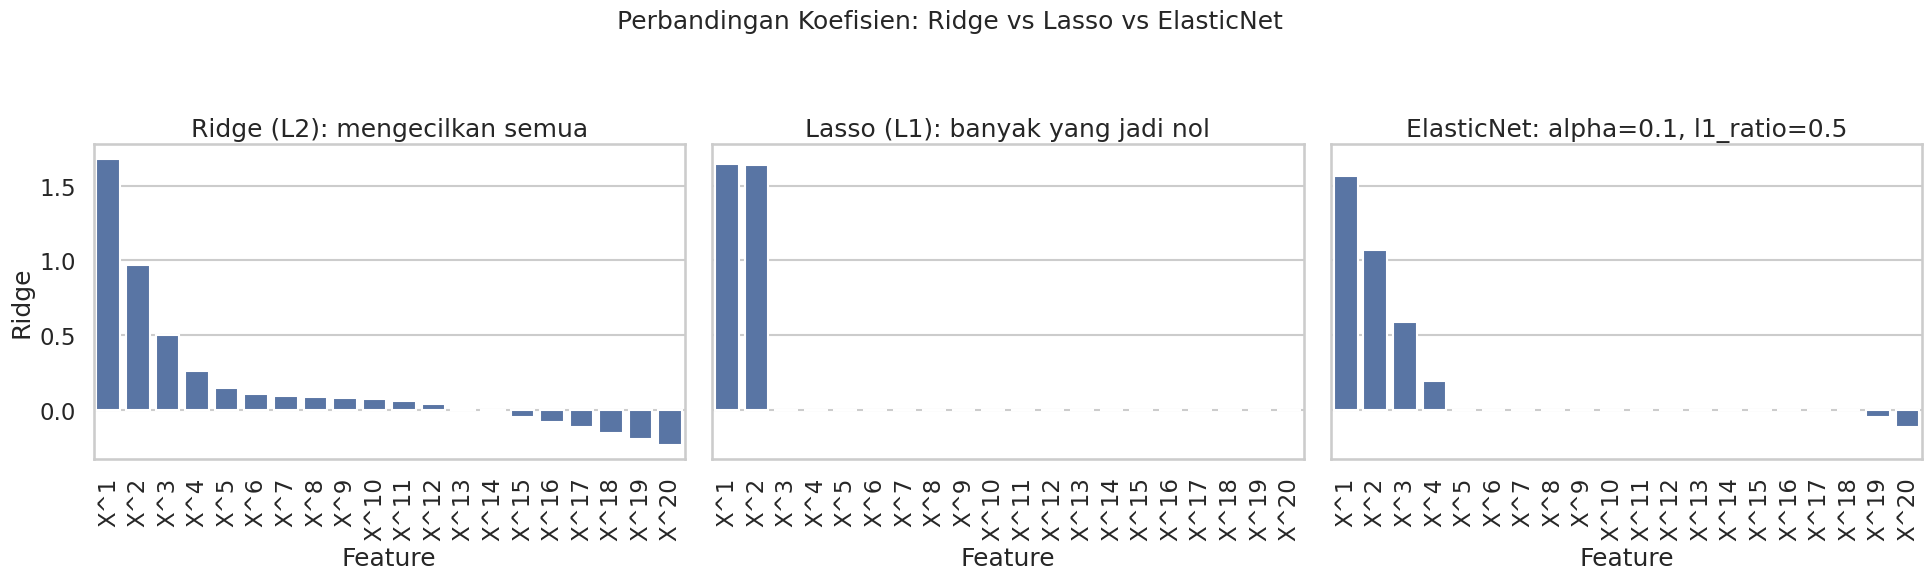

In [11]:
# Plot perbandingan koefisien (lebih ringkas daripada lesson_05 agar terbaca)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
fig.suptitle("Perbandingan Koefisien: Ridge vs Lasso vs ElasticNet", fontsize=18)

sns.barplot(ax=axes[0], x="Feature", y="Ridge", data=coeffs_df)
axes[0].set_title("Ridge (L2): mengecilkan semua")
axes[0].tick_params(axis="x", rotation=90)

sns.barplot(ax=axes[1], x="Feature", y="Lasso", data=coeffs_df)
axes[1].set_title("Lasso (L1): banyak yang jadi nol")
axes[1].tick_params(axis="x", rotation=90)

sns.barplot(ax=axes[2], x="Feature", y="ElasticNet", data=coeffs_df)
axes[2].set_title(f"ElasticNet: alpha={alpha}, l1_ratio={l1_ratio}")
axes[2].tick_params(axis="x", rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [12]:
# Bonus: hitung berapa koefisien yang nol (sparsity)
def count_zeros(arr, eps=0.0):
    if eps == 0.0:
        return int(np.sum(arr == 0))
    return int(np.sum(np.abs(arr) <= eps))

print("Jumlah koefisien nol:")
print("- Ridge     :", count_zeros(ridge_coeffs))
print("- Lasso     :", count_zeros(lasso_coeffs))
print("- ElasticNet:", count_zeros(elastic_net_coeffs))

Jumlah koefisien nol:
- Ridge     : 0
- Lasso     : 18
- ElasticNet: 14


---
## 5) Visualisasi: tanpa regularisasi vs ElasticNet
Di bawah ini kita bandingkan *garis prediksi* dari:
- **Tanpa regularisasi**: `LinearRegression` pada fitur polinomial yang sama
- **Dengan regularisasi**: `ElasticNet`
Keduanya memakai preprocessing yang sama (poly + scaling), jadi perbedaannya benar-benar dari regularisasinya.

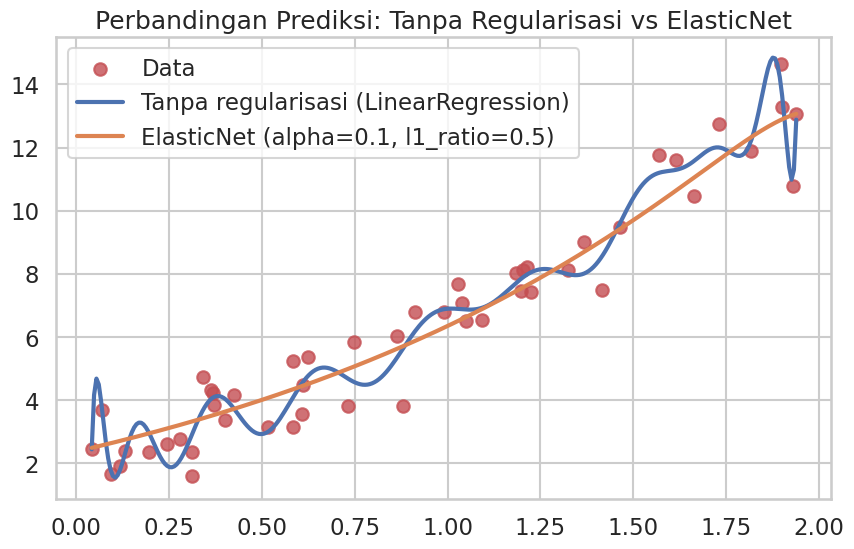

In [13]:
# Fit model pembanding (tanpa regularisasi) di fitur yang sama
lin_reg = LinearRegression()
lin_reg.fit(X_poly_scaled, y)

# Buat grid X untuk plot garis prediksi
X_new = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
X_new_poly = poly.transform(X_new)
X_new_poly_scaled = scaler.transform(X_new_poly)

y_pred_no_reg = lin_reg.predict(X_new_poly_scaled)
y_pred_elastic = elastic_net.predict(X_new_poly_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="r", alpha=0.8, label="Data")
plt.plot(X_new, y_pred_no_reg, linewidth=3, label="Tanpa regularisasi (LinearRegression)")
plt.plot(X_new, y_pred_elastic, linewidth=3, label=f"ElasticNet (alpha={alpha}, l1_ratio={l1_ratio})")
plt.title("Perbandingan Prediksi: Tanpa Regularisasi vs ElasticNet")
plt.legend()
plt.show()